# 02. Preprocessing

## Objective
Prepare the data for modeling using **NumPy exclusively**.
**New**: Implements Advanced Feature Engineering (Interactions & Polynomials) to capture non-linear relationships.

## 1. Load Data

In [64]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = '../data/raw/AB_NYC_2019.csv'

def load_data(file_path):
    with open(file_path, mode='r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        data = list(reader)
    return header, np.array(data, dtype=object)

header, data = load_data(DATA_PATH)

# Define the specific data type for each field
# Using native types (int64, float64, datetime) enables vectorization
dtype = np.dtype([
    ('id', np.int64),
    ('name', 'U100'),
    ('host_id', np.int64),
    ('host_name', 'U50'),
    ('neighbourhood_group', 'U50'),
    ('neighbourhood', 'U50'),
    ('latitude', np.float64),
    ('longitude', np.float64),
    ('room_type', 'U20'),
    ('price', np.int32),
    ('minimum_nights', np.int32),
    ('number_of_reviews', np.int32),
    ('last_review', 'M8[D]'),           # NumPy datetime format
    ('reviews_per_month', np.float64),
    ('calculated_host_listings_count', np.int32),
    ('availability_365', np.int32)
])


## 2. Handling Missing Values

In [65]:
N = len(data)

missing_counts_array = np.zeros(len(header), dtype=int)
for i, col_name in enumerate(header):
    column_data = data[:, i]
    
    missing_counts_array[i] = np.sum(column_data == '')

print("{:<30} {:<10} {:<10}".format("Col", "Missing", "(%)"))
print("-" * 50)

for i, col_name in enumerate(header):
    count = missing_counts_array[i]
    
    if count > 0:
        percent = (count / N) * 100
        print("{:<30} {:<10} {:<10.2f}".format(col_name, count, percent))

Col                            Missing    (%)       
--------------------------------------------------
name                           16         0.03      
host_name                      21         0.04      
last_review                    10052      20.56     
reviews_per_month              10052      20.56     


### Structuring the Data

In [66]:
# Helpers for vectorized cleaning of empty strings
def clean_int(arr):
    # Replace empty strings with 0 before converting
    return np.where(arr == '', '0', arr).astype(np.int32)

def clean_float(arr):
    # Replace empty strings with nan before converting
    return np.where(arr == '', 'nan', arr).astype(np.float64)

def clean_date(arr):
    # Replace empty strings with NaT (Not a Time) before converting
    return np.where(arr == '', 'NaT', arr).astype('M8[D]')

# Create a new empty structured array
N = len(data)
structured_data = np.zeros(N, dtype=dtype)

# Assign columns using vectorized conversion
# data[:, i] extracts the column from the raw string array
structured_data['id'] = data[:, 0].astype(np.int64)
structured_data['name'] = data[:, 1]
structured_data['host_id'] = data[:, 2].astype(np.int64)
structured_data['host_name'] = data[:, 3]
structured_data['neighbourhood_group'] = data[:, 4]
structured_data['neighbourhood'] = data[:, 5]
structured_data['latitude'] = clean_float(data[:, 6])
structured_data['longitude'] = clean_float(data[:, 7])
structured_data['room_type'] = data[:, 8]
structured_data['price'] = clean_int(data[:, 9])
structured_data['minimum_nights'] = clean_int(data[:, 10])
structured_data['number_of_reviews'] = clean_int(data[:, 11])
structured_data['last_review'] = clean_date(data[:, 12])
structured_data['reviews_per_month'] = clean_float(data[:, 13])
structured_data['calculated_host_listings_count'] = clean_int(data[:, 14])
structured_data['availability_365'] = clean_int(data[:, 15])

data = structured_data
print("New Data Shape:", data.shape)
print("Dtype Names:", data.dtype.names)
print("\nFirst 3 rows (structured):")
print(data[:3])

os.makedirs('../data/processed', exist_ok=True)

New Data Shape: (48895,)
Dtype Names: ('id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365')

First 3 rows (structured):
[(2539, 'Clean & quiet apt home by the park', 2787, 'John', 'Brooklyn', 'Kensington', 40.64749, -73.97237, 'Private room', 149, 1,  9, '2018-10-19', 0.21, 6, 365)
 (2595, 'Skylit Midtown Castle', 2845, 'Jennifer', 'Manhattan', 'Midtown', 40.75362, -73.98377, 'Entire home/apt', 225, 1, 45, '2019-05-21', 0.38, 2, 355)
 (3647, 'THE VILLAGE OF HARLEM....NEW YORK !', 4632, 'Elisabeth', 'Manhattan', 'Harlem', 40.80902, -73.9419 , 'Private room', 150, 3,  0,        'NaT',  nan, 1, 365)]


- **reviews_per_month**: Replace NaN with 0.

In [67]:
data['reviews_per_month'] = np.nan_to_num(
    data['reviews_per_month'], 
    nan=0
)

## 3. Outlier Treatment & Transformation
- **Price**: Log transformation (`np.log1p`).
- **Outlier Removal**: Log-Price IQR.

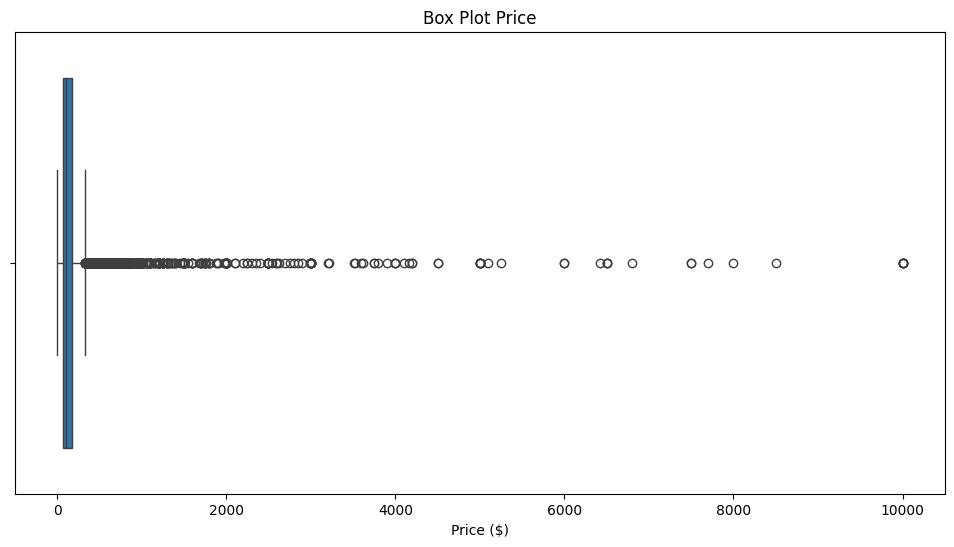

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['price'])
plt.title('Box Plot Price')
plt.xlabel('Price ($)')
plt.show()

Should we remove extremely high prices?
Is it a data entry error or are these high prices due to luxury services?

In [69]:
old_dtype = data.dtype.descr
new_field = ('price_log', np.float64)
new_dtype_list = list(old_dtype)
new_dtype_list.append(new_field)
new_dtype = np.dtype(new_dtype_list)

data_extended = np.empty(data.shape, dtype=new_dtype)
for name in data.dtype.names:
    data_extended[name] = data[name]

data_extended['price_log'] = np.log(data_extended['price'] + 1)

data = data_extended

In [70]:
len_original_for_log_filter = len(data)
Q1_log = np.percentile(data['price_log'], 25)
Q3_log = np.percentile(data['price_log'], 75)
IQR_log = Q3_log - Q1_log

LOWER_BOUND_log = Q1_log - 1.5 * IQR_log
UPPER_BOUND_log = Q3_log + 1.5 * IQR_log

outlier_mask_log = (data['price_log'] >= LOWER_BOUND_log) & (data['price_log'] <= UPPER_BOUND_log)

data_clean_log = data[outlier_mask_log]
data = data_clean_log

print(f"Q1 LOG: {Q1_log:.4f}")
print(f"Q3 LOG: {Q3_log:.4f}")
print(f"IQR LOG: {IQR_log:.4f}")
print(f"LOWER_BOUND LOG: {LOWER_BOUND_log:.4f}")
print(f"UPPER_BOUND LOG: {UPPER_BOUND_log:.4f}")

print("-" * 30)
print(f"Original Data (LOG) : {len_original_for_log_filter}")
print(f"Outlier Removed: {len_original_for_log_filter - len(data_clean_log)}")
print(f"Data Cleaned: {len(data_clean_log)}")

Q1 LOG: 4.2485
Q3 LOG: 5.1705
IQR LOG: 0.9220
LOWER_BOUND LOG: 2.8655
UPPER_BOUND LOG: 6.5535
------------------------------
Original Data (LOG) : 48895
Outlier Removed: 637
Data Cleaned: 48258


<Figure size 1200x600 with 0 Axes>

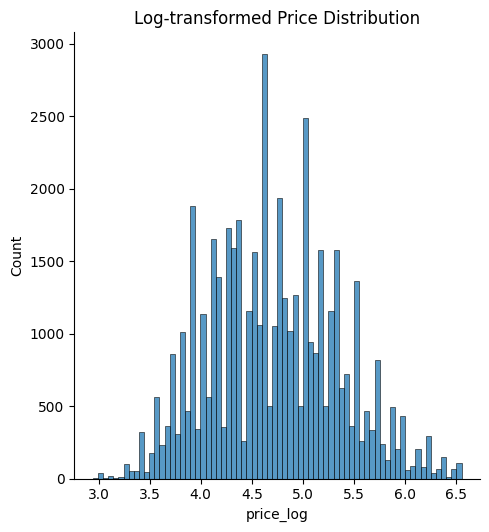

In [71]:
plt.figure(figsize=(12, 6))
sns.displot(x=data['price_log'])
plt.title('Log-transformed Price Distribution')
plt.xlabel('price_log')
plt.show()

In [72]:
print("New Data Shape:", data.shape)
print("Dtype Names:", data.dtype.names)
print("\nFirst 3 rows (structured):")
print(data[:3])

New Data Shape: (48258,)
Dtype Names: ('id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price_log')

First 3 rows (structured):
[(2539, 'Clean & quiet apt home by the park', 2787, 'John', 'Brooklyn', 'Kensington', 40.64749, -73.97237, 'Private room', 149, 1,  9, '2018-10-19', 0.21, 6, 365, 5.01063529)
 (2595, 'Skylit Midtown Castle', 2845, 'Jennifer', 'Manhattan', 'Midtown', 40.75362, -73.98377, 'Entire home/apt', 225, 1, 45, '2019-05-21', 0.38, 2, 355, 5.420535  )
 (3647, 'THE VILLAGE OF HARLEM....NEW YORK !', 4632, 'Elisabeth', 'Manhattan', 'Harlem', 40.80902, -73.9419 , 'Private room', 150, 3,  0,        'NaT', 0.  , 1, 365, 5.01727984)]


## 4. One-Hot Encoding
Encode `neighbourhood_group` and `room_type`. **Drop first category** to avoid Dummy Variable Trap.

In [73]:
def one_hot_encode_numpy(data_array, col_name, drop_first=True):

    categorical_column = data_array[col_name]
    
    unique_values = np.unique(categorical_column)
    
    if drop_first and len(unique_values) > 1:
        unique_values = unique_values[1:] 
    
    encoded_columns = []
    new_col_names = []
    
    for value in unique_values:
        mask = (categorical_column == value)
        encoded_column = mask.astype(np.float64)
        # Store as float for consistency with scaled features
        
        encoded_columns.append(encoded_column)
        new_col_names.append(f'{col_name}_{value}')
        
    return encoded_columns, new_col_names

In [74]:
COLS_TO_ENCODE = ['neighbourhood_group', 'room_type']
COLS_TO_DROP = ['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood']
COLS_TO_KEEP = [name for name in data.dtype.names if name not in COLS_TO_ENCODE and name not in COLS_TO_DROP]

encoded_features = []
encoded_names = []

# vectorized
kept_features = [data[name] for name in COLS_TO_KEEP]
kept_names = COLS_TO_KEEP

for col in COLS_TO_ENCODE:
    arrays, names = one_hot_encode_numpy(data, col, drop_first=True)
    encoded_features.extend(arrays)
    encoded_names.extend(names)

final_data_matrix = np.column_stack(kept_features + encoded_features)

final_names = kept_names + encoded_names
final_dtypes_list = []

for name in kept_names:
    final_dtypes_list.append((name, data[name].dtype))

for name in encoded_names:
    final_dtypes_list.append((name, np.float64))
    
final_dtype = np.dtype(final_dtypes_list)

data_final = np.empty(final_data_matrix.shape[0], dtype=final_dtype)
for i, name in enumerate(final_names):
    data_final[name] = final_data_matrix[:, i] 

data = data_final 


In [75]:
print(f"Data have {len(data)} rows and {len(data.dtype.names)} columns.")
print("One-Hot columns created:")
print([name for name in data.dtype.names if name.startswith(('neighbourhood_group_', 'room_type_'))])
print("\nFirst few rows of preprocessed data:")
print(data.dtype)
print(data[:1])

Data have 48258 rows and 15 columns.
One-Hot columns created:
['neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Private room', 'room_type_Shared room']

First few rows of preprocessed data:
[('latitude', '<f8'), ('longitude', '<f8'), ('price', '<i4'), ('minimum_nights', '<i4'), ('number_of_reviews', '<i4'), ('reviews_per_month', '<f8'), ('calculated_host_listings_count', '<i4'), ('availability_365', '<i4'), ('price_log', '<f8'), ('neighbourhood_group_Brooklyn', '<f8'), ('neighbourhood_group_Manhattan', '<f8'), ('neighbourhood_group_Queens', '<f8'), ('neighbourhood_group_Staten Island', '<f8'), ('room_type_Private room', '<f8'), ('room_type_Shared room', '<f8')]
[(40.64749, -73.97237, 149, 1, 9, 0.21, 6, 365, 5.01063529, 1., 0., 0., 0., 1., 0.)]


## 5. Features Engineering & Scaling
1. **Interaction Terms**: Create new features interactions.
2. **Standard Scaling**: Scale continuous features.

In [76]:
epsilon = 1e-6 
review_activity = data['reviews_per_month'] / (data['minimum_nights'] + epsilon)
review_activity = np.round(review_activity, 2).astype(np.float64) 
review_quality_score = data['number_of_reviews'] / (data['minimum_nights'] + epsilon)
review_quality_score = np.round(review_quality_score, 2).astype(np.float64)

# Interaction: minimum_nights * reviews_per_month
interaction_nights_reviews = data['minimum_nights'] * data['reviews_per_month']

LAT_MIN, LAT_MAX = 40.73, 40.80
LONG_MIN, LONG_MAX = -74.01, -73.95

is_core_zone_mask = (data['latitude'] > LAT_MIN) & (data['latitude'] < LAT_MAX) & \
                    (data['longitude'] > LONG_MIN) & (data['longitude'] < LONG_MAX)

is_high_value_core = is_core_zone_mask.astype(np.float64)

old_dtype = data.dtype.descr
new_fields = [
    ('review_activity', np.float64),
    ('review_quality_score', np.float64),
    ('is_high_value_core', np.float64),
    ('interaction_nights_reviews', np.float64)
]
# Update dtypes of cols to scale to float64 if not already
cols_to_scale = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                 'calculated_host_listings_count', 'availability_365',
                 'review_activity', 'review_quality_score', 
                 'interaction_nights_reviews']

updated_dtype_list = []
for name, typ in old_dtype:
    if name in cols_to_scale:
        updated_dtype_list.append((name, np.float64))
    else:
        updated_dtype_list.append((name, typ))

for name, typ in new_fields:
    if name in cols_to_scale:
         updated_dtype_list.append((name, np.float64))
    else:
         updated_dtype_list.append((name, typ))

new_dtype = np.dtype(updated_dtype_list)
data_new = np.empty(data.shape, dtype=new_dtype)

for name in data.dtype.names:
    data_new[name] = data[name].astype(data_new.dtype[name])

data_new['review_activity'] = review_activity
data_new['review_quality_score'] = review_quality_score
data_new['is_high_value_core'] = is_high_value_core
data_new['interaction_nights_reviews'] = interaction_nights_reviews

# --- Apply Standard Scaling ---
for col in cols_to_scale:
    col_data = data_new[col]
    mean = np.mean(col_data)
    std = np.std(col_data)
    if std == 0:
        std = 1
    
    data_new[col] = (col_data - mean) / std

data = data_new

In [77]:
print(f"Data have {len(data)} rows and {len(data.dtype.names)} columns.")
print("Cols scaled:", cols_to_scale)
print("\nFirst few rows of preprocessed data:")
print(data.dtype)
print(data[:1])

Data have 48258 rows and 19 columns.
Cols scaled: ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'review_activity', 'review_quality_score', 'interaction_nights_reviews']

First few rows of preprocessed data:
[('latitude', '<f8'), ('longitude', '<f8'), ('price', '<i4'), ('minimum_nights', '<f8'), ('number_of_reviews', '<f8'), ('reviews_per_month', '<f8'), ('calculated_host_listings_count', '<f8'), ('availability_365', '<f8'), ('price_log', '<f8'), ('neighbourhood_group_Brooklyn', '<f8'), ('neighbourhood_group_Manhattan', '<f8'), ('neighbourhood_group_Queens', '<f8'), ('neighbourhood_group_Staten Island', '<f8'), ('room_type_Private room', '<f8'), ('room_type_Shared room', '<f8'), ('review_activity', '<f8'), ('review_quality_score', '<f8'), ('is_high_value_core', '<f8'), ('interaction_nights_reviews', '<f8')]
[(40.64749, -73.97237, 149, -0.29459127, -0.32313871, -0.55446756, -0.03535703, 1.93043106, 5.01063529, 1., 0., 0

## 6. Save processed data to CSV


In [78]:
PROCESSED_DATA_PATH = '../data/processed/airbnb_processed.csv'

os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)

header = data.dtype.names

def save_numpy_structured_to_csv(structured_array, file_path, header):
    with open(file_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        
        writer.writerow(header)
        
        for row in structured_array:
            row_data = list(row.astype(object))
            writer.writerow(row_data)

save_numpy_structured_to_csv(data, PROCESSED_DATA_PATH, header)